In [1]:
import sys
!{sys.executable} -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

#### Read manulay compiled csv, from logs that we know some of their content finished in weird.log bin. Hypotheticaly they have more chance of having anomalyes that are correlated to the remaining network traffic parameter's. 


In [4]:
df = pd.read_json('/home/vlado/Desktop/untitled/26.8-30.8/compiled 26-30/conn_log/conn_log.json', lines = True)

### Izbaci prvi stupac, jer je to TimeStamp. 
### Samo jednom pokrenuti, inace brise iduci nulti stupac!

In [3]:
df=df.drop(df.columns[0], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12749 entries, 0 to 12748
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uid            12749 non-null  object 
 1   id.orig_h      12749 non-null  object 
 2   id.orig_p      12749 non-null  int64  
 3   id.resp_h      12749 non-null  object 
 4   id.resp_p      12749 non-null  int64  
 5   proto          12749 non-null  object 
 6   service        4820 non-null   object 
 7   duration       8469 non-null   float64
 8   orig_bytes     8469 non-null   float64
 9   resp_bytes     8469 non-null   float64
 10  conn_state     12749 non-null  object 
 11  local_orig     12749 non-null  bool   
 12  local_resp     12749 non-null  bool   
 13  missed_bytes   12749 non-null  int64  
 14  history        8349 non-null   object 
 15  orig_pkts      12749 non-null  int64  
 16  orig_ip_bytes  12749 non-null  int64  
 17  resp_pkts      12749 non-null  int64  
 18  resp_i

## Ploting an univariate distribution of observations in dataset, for responsed ip bytes parameter, eda-analysis

count    1.985390e+05
mean     6.765486e+04
std      2.594193e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.155728e+10
Name: resp_ip_bytes, dtype: float64


/home/vlado/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/vlado/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


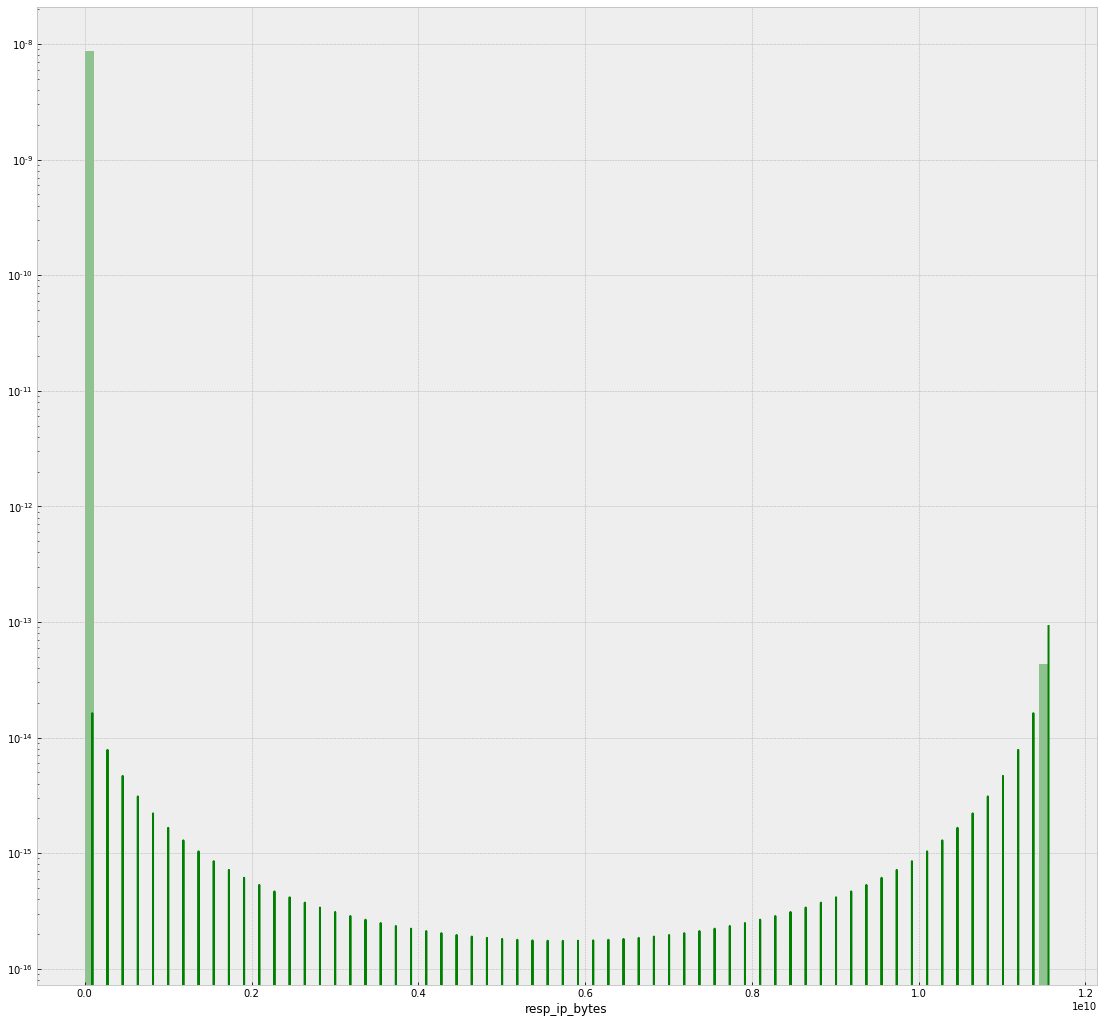

In [5]:
print(df['resp_ip_bytes'].describe())
plt.figure(figsize=(19, 18))
sns.distplot(df['resp_ip_bytes'], color='g', bins=100, hist_kws={'alpha': 0.4,'log':True});

### Izaberi samo brojčane vrijednosti iz dataseta

In [6]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

ts  id.orig_p  id.resp_p  duration  orig_bytes  resp_bytes  \
0  1.566824e+09      42064       1900  3.001863       688.0         0.0   
1  1.566824e+09      50598       4506  3.027828         0.0         0.0   
2  1.566824e+09      52149         53  0.014235       191.0       319.0   
3  1.566824e+09      48998         53  0.021023       103.0       217.0   
4  1.566824e+09      60754         53  0.016985       191.0       319.0   

   missed_bytes  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  
0             0          4            800          0              0  
1             0          3            180          0              0  
2             0          2            247          2            375  
3             0          2            159          2            273  
4             0          2            247          2            375

### Iscrtaj histogram svih preostalih vrijednosti dataseta

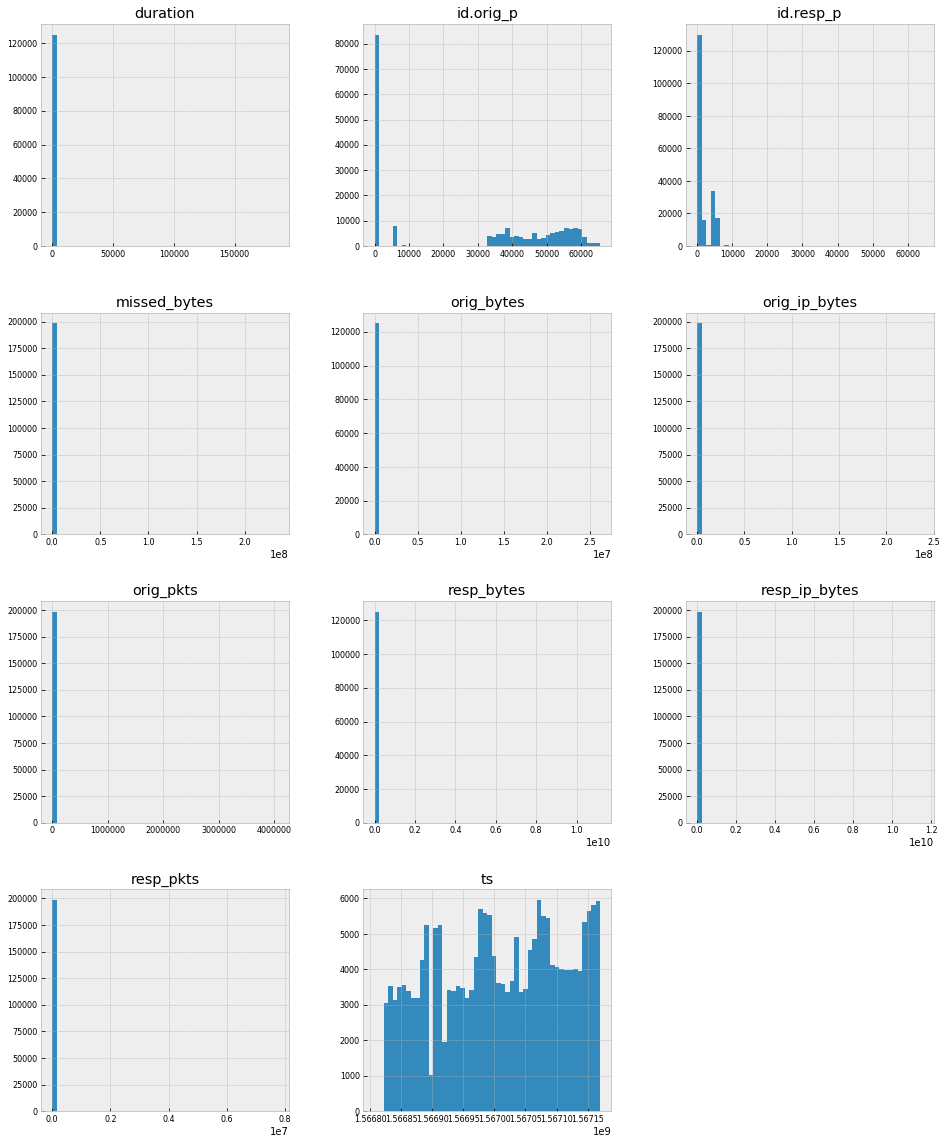

In [7]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Pronađi korelaciju odabranog parametra sa ostalim parametrima 
###  u ovom slučaju promašenih bajtova sa ostalim parametrima

In [8]:
df_num_corr = df_num.corr()['missed_bytes'][:-5] # 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.2].sort_values(ascending=False)
print("There is {} strongly correlated values with missed_bytes:\n{}".format(len(golden_features_list), golden_features_list))

There is 2 strongly correlated values with missed_bytes:
resp_bytes    0.995584
orig_bytes    0.843647
Name: missed_bytes, dtype: float64


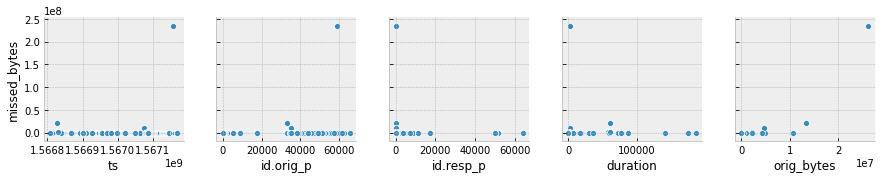

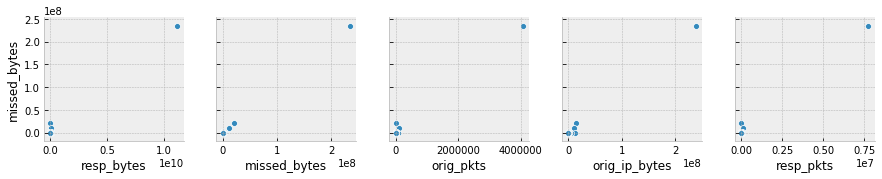

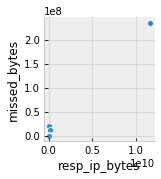

In [9]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['missed_bytes'])

## Prikaz distribucije parametara bez maksimalne vrijednosti, radi bolje razlučivosti , u slučaju parametra missed bytes

In [76]:
df_without_largest = pd.read_json('/home/vlado/Desktop/untitled/26.8-30.8/compiled 26-30/conn_log/conn_log.json', lines = True)

## find largest element and remove it

In [105]:
wo_largest = df_without_largest.nlargest(1, 'orig_pkts').index      
df_without_largest.drop(wo_largest, inplace= True)

## include only numbers

In [25]:
# df_num_wl = df_without_largest.select_dtypes(include = ['float64', 'int64'])

## add new collumn and connect it with conn_state

In [85]:
df_without_largest['conn_state'] = df_without_largest['conn_state'].astype('category')
c = df_without_largest['conn_state'].astype('category')
labels = dict(enumerate(c.cat.categories))
df_without_largest['color_encoded'] = df_without_largest['conn_state'].cat.codes

## this line checks mapping accuracy for individual color assigned to state

In [13]:
# df_without_largest.loc[df_without_largest['conn_state'] =='RSTOS0']

## change value of new color_encoded column to integer, so it can be used as parameter when plotting

In [106]:
df_without_largest['color_encoded'] = df_without_largest['color_encoded'].astype('int64')
df_without_largest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198538 entries, 0 to 198538
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ts             198538 non-null  float64 
 1   uid            198538 non-null  object  
 2   id.orig_h      198538 non-null  object  
 3   id.orig_p      198538 non-null  int64   
 4   id.resp_h      198538 non-null  object  
 5   id.resp_p      198538 non-null  int64   
 6   proto          198538 non-null  object  
 7   duration       125221 non-null  float64 
 8   orig_bytes     125221 non-null  float64 
 9   resp_bytes     125221 non-null  float64 
 10  conn_state     198538 non-null  category
 11  local_orig     198538 non-null  bool    
 12  local_resp     198538 non-null  bool    
 13  missed_bytes   198538 non-null  int64   
 14  history        127268 non-null  object  
 15  orig_pkts      198538 non-null  int64   
 16  orig_ip_bytes  198538 non-null  int64   
 17  resp_pkts 

## In this cell, labels define names for assigned color number. '0' = 'OTH', '1' = 'RST0', etc.

## It is visible in this graph for each parameter and in what state that value been. Colors need to bee adjusted for clearer picture

## legend show's connection's with conn_state value and color

{0: 'OTH', 1: 'RSTO', 2: 'RSTOS0', 3: 'RSTR', 4: 'RSTRH', 5: 'S0', 6: 'S1', 7: 'S2', 8: 'SF', 9: 'SHR'}

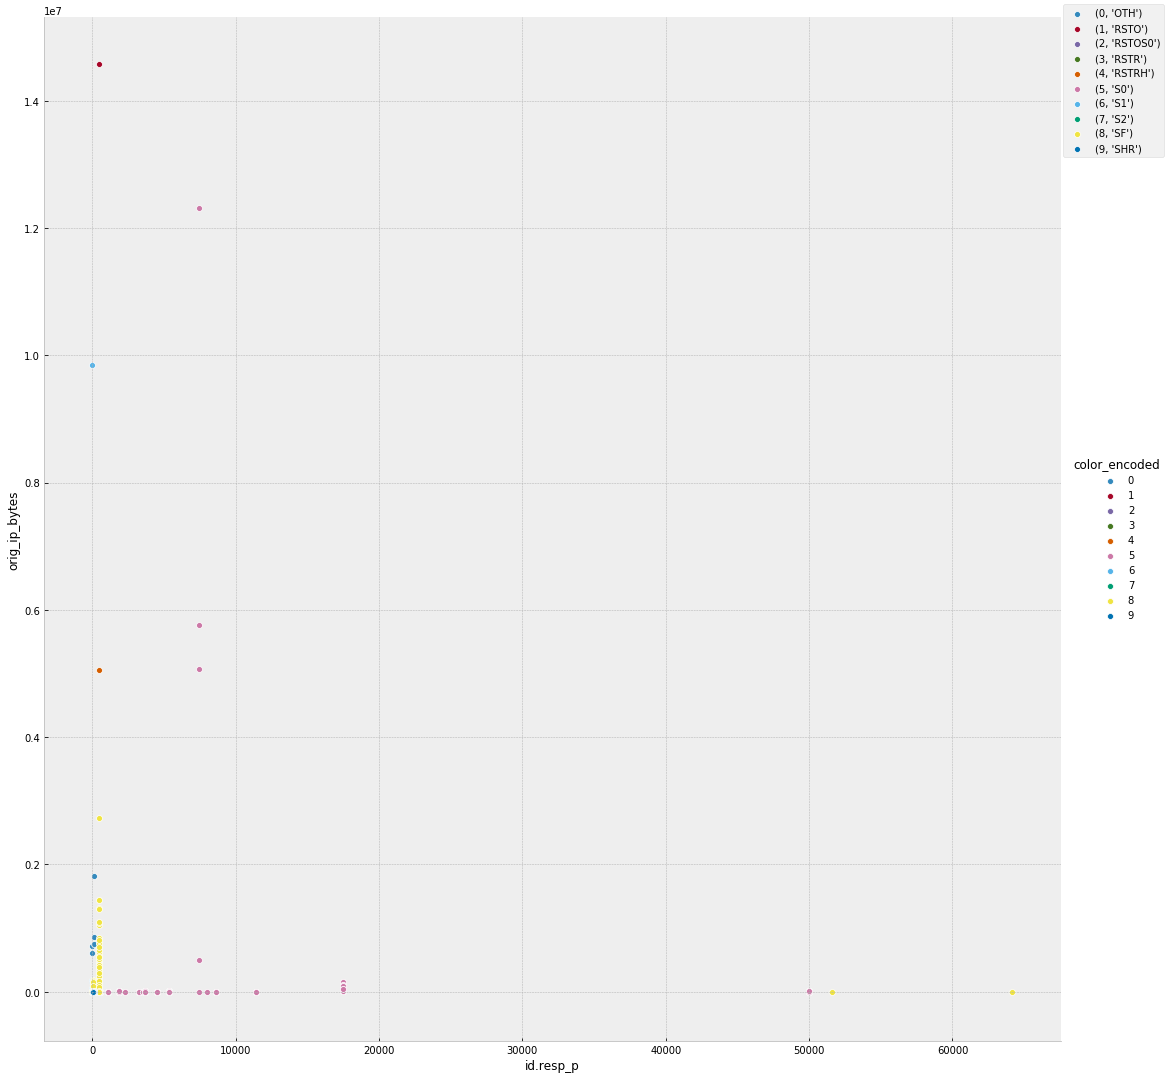

In [108]:
df_num_wl = df_without_largest.select_dtypes(include = ['float64', 'int64'])

a = sns.pairplot(data=df_without_largest, hue = 'color_encoded', kind='scatter', height=15,            
                x_vars=df_without_largest.columns[5],
                y_vars=['orig_ip_bytes'])

lab = dict.items(labels)

a.fig.legend(labels=lab, loc='upper right', ncol=1)


# Ovaj primjer plotanja vrijednosti stanja smo radili zbog moguce veze izmedu anomalije i flaga conn_state-a, no medutim ocito je da se razlicita stanja pojavljuju kod vrijednosti koje su outlayeri u ovom slučaju

## Heatmap of correlated values without max value from df

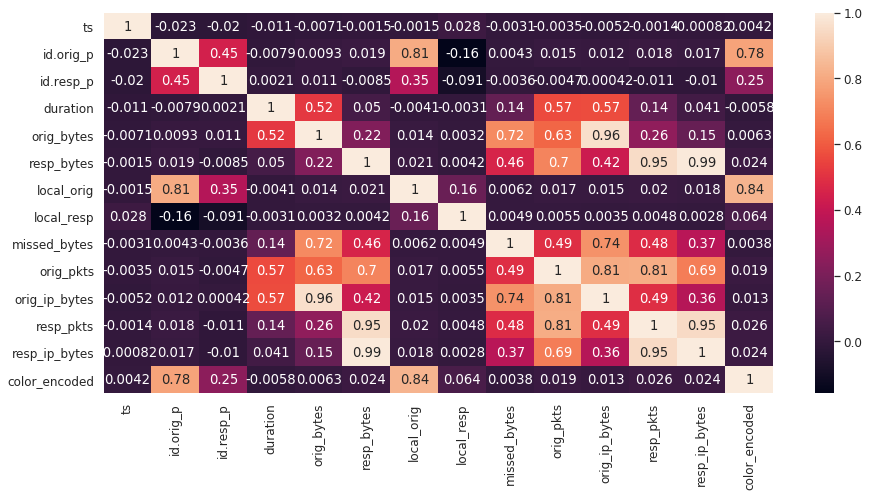

In [110]:
plt.figure(figsize=(15,7))
sns.set(font_scale=1.1)
sns.heatmap(df_without_largest.corr(),annot=True)

## Numerical output of correlated values 

In [17]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # 
    tmpDf = df_num[[df_num.columns[i], 'resp_ip_bytes']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['resp_ip_bytes'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

      id.resp_p: -0.031652670687127585
      id.orig_p: 0.03497806146759766
       duration: 0.06301281695415685
     orig_bytes: 0.9240796595253773
   missed_bytes: 0.9587992284010454
  orig_ip_bytes: 0.9706737090824706
      orig_pkts: 0.9845066772958757
      resp_pkts: 0.989442837458336
     resp_bytes: 0.9997432241309193


## RESEARCPY 

In [111]:
import sys
!{sys.executable} -m pip install researchpy
import researchpy as rp

rp.summary_cont(df["duration"])

Variable         N       Mean           SD        SE  95% Conf.   Interval
0  duration  125222.0  59.385924  1253.804858  3.543151  52.441409  66.330439

### Possible connection state values:
    
S0: Connection attempt seen, no reply.
S1: Connection established, not terminated.
SF: Normal establishment and termination. Note that this is the same symbol as for state S1. You can tell the two 
apart because for S1 there will not be any byte counts in the summary, while for SF there will be.

REJ: Connection attempt rejected.

S2: Connection established and close attempt by originator seen (but no reply from responder).

S3: Connection established and close attempt by responder seen (but no reply from originator).

RSTO: Connection established, originator aborted (sent a RST).

RSTR: Responder sent a RST.

RSTOS0: Originator sent a SYN followed by a RST, we never saw a SYN-ACK from the responder.

RSTRH: Responder sent a SYN ACK followed by a RST, we never saw a SYN from the (purported) originator.

SH: Originator sent a SYN followed by a FIN, we never saw a SYN ACK from the responder (hence the connection was “half” open).

SHR: Responder sent a SYN ACK followed by a FIN, we never saw a SYN from the originator.

OTH: No SYN seen, just midstream traffic (a “partial connection” that was not later closed).

### Some of this state values allready indicate bad network behavior, so we try to isolate them, and coorelate with interesting parameters, left alone values are anomalies.

## Plotting the number of repeated connection state's, and associated condition.  

conn_state
S0         81661
OTH        71279
SF         45156
RSTO         215
RSTR         146

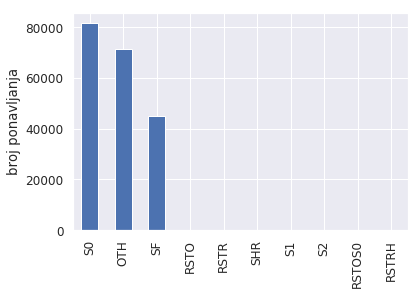

In [112]:
broj_ponavljanja = pd.value_counts(df['conn_state'])
dataframe_ponavljanja = pd.DataFrame(broj_ponavljanja)


conn_plot = plot_number_of_values = pd.value_counts(df['conn_state']).plot.bar()
conn_plot.set_ylabel('broj ponavljanja')
dataframe_ponavljanja.head()
# a = dataframe_ponavljanja.iloc[0].value_counts
# print (a)

### Creating the dataframe where connection state is just value : 'OTH'

In [113]:
df_OTH = df[df.conn_state == 'OTH']

### Summary of duration and orig_bytes in OTH dataframe

In [114]:
rp.summary_cont(df_OTH[["duration", 'orig_bytes']])


Variable        N        Mean           SD         SE   95% Conf.  \
0    duration  43769.0   74.592921  1179.516273   5.637942   63.542451   
1  orig_bytes  43769.0  154.483767  2928.691041  13.998782  127.045900   

     Interval  
0   85.643390  
1  181.921634

## Uključi samo brojčane vrijednosti u novi dataframe (OTH) i pronađi korelaciju missed_bytes sa drugim parametrima, u OTH dataframeu

In [115]:
# list(set(df.dtypes.tolist()))
df_num_oth = df_OTH.select_dtypes(include = ['float64', 'int64'])
df_num_oth.head()
df_num_corr1 = df_num_oth.corr()['missed_bytes'][:-5]
golden_features_list = df_num_corr1[abs(df_num_corr1) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with missed_bytes:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with missed_bytes:
Series([], Name: missed_bytes, dtype: float64)


### Plotaj korelirane vrijednosti za svaki parametar

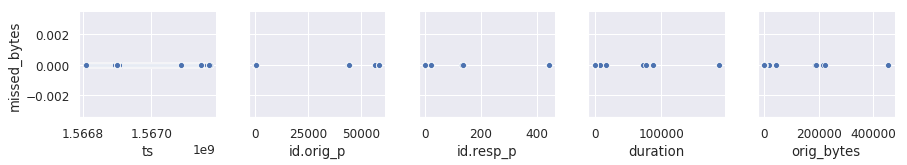

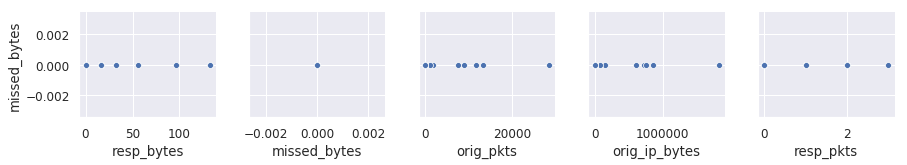

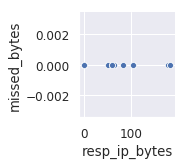

In [116]:
for i in range(0, len(df_num_oth.columns), 5):
    sns.pairplot(data=df_num_oth,
                x_vars=df_num_oth.columns[i:i+5],
                y_vars=['missed_bytes'])
    

## Ista stvar, kreiraj df sa SF connection parametrom, pronađi korelacije i plotaj

In [117]:
df_SF = df[df.conn_state == 'SF']
# rp.summary_cont(df_SF[["duration", 'orig_bytes']])
df_num_SF = df_SF.select_dtypes(include = ['float64', 'int64'])
# df_num_SF.head()

df_num_corr2 = df_num_SF.corr()['orig_ip_bytes'][:-3]
golden_features_list = df_num_corr2[abs(df_num_corr2) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with orig_ip_bytes:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with orig_ip_bytes:
orig_pkts       0.840519
orig_bytes      0.773591
resp_bytes      0.667133
missed_bytes    0.593906
duration        0.510432
Name: orig_ip_bytes, dtype: float64


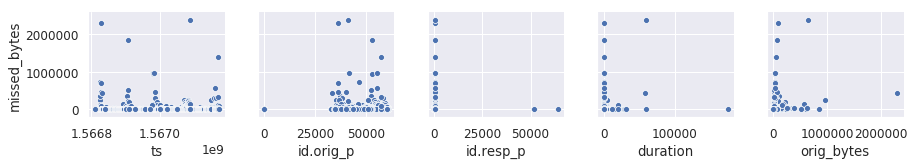

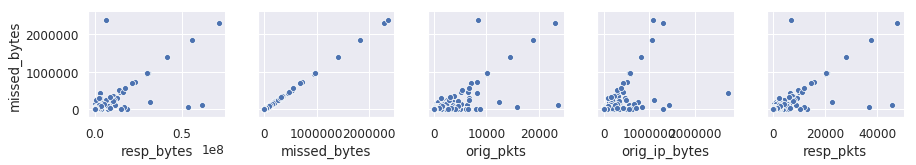

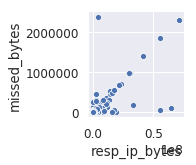

In [118]:
for i in range(0, len(df_num_SF.columns), 5):
    sns.pairplot(data=df_num_SF,
                x_vars=df_num_SF.columns[i:i+5],
                y_vars=['missed_bytes'])

In [26]:
# df_SF.nlargest(50, 'missed_bytes')


## Dataframe i plot, S1 parametra

In [119]:
df_S1 = df[df.conn_state == 'S1']
# rp.summary_cont(df_SF[["duration", 'orig_bytes']])
df_num_S1 = df_S1.select_dtypes(include = ['float64', 'int64'])
df_num_S1.head()

df_num_corr3 = df_num_S1.corr()['orig_ip_bytes'][:-3] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr3[abs(df_num_corr3) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with orig_ip_bytes:\n{}".format(len(golden_features_list), golden_features_list))

There is 7 strongly correlated values with orig_ip_bytes:
missed_bytes    0.999974
orig_pkts       0.999857
resp_bytes      0.999503
orig_bytes      0.990621
ts              0.378241
id.orig_p       0.334370
id.resp_p      -0.480189
Name: orig_ip_bytes, dtype: float64


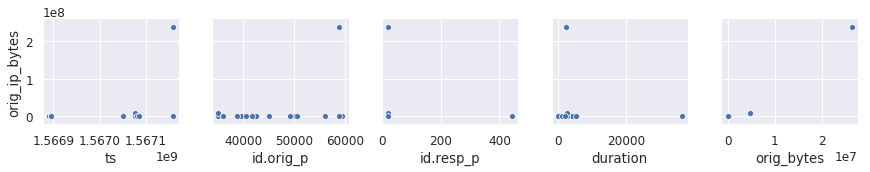

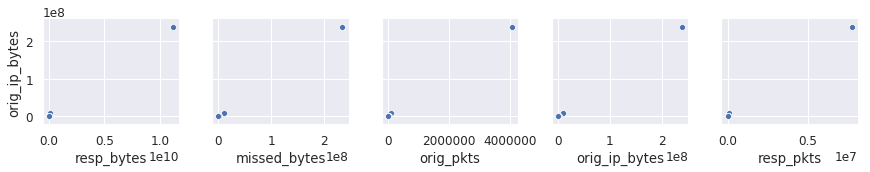

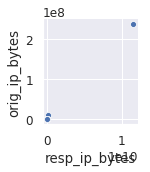

In [120]:
for i in range(0, len(df_num_S1.columns), 5):
    sns.pairplot(data=df_num_S1,
                x_vars=df_num_S1.columns[i:i+5],
                y_vars=['orig_ip_bytes'])

## Dataframe i plot 'RST0' parametra

In [121]:
df_RSTO = df[df.conn_state == 'RSTO']
df_num_RSTO = df_RSTO.select_dtypes(include = ['float64', 'int64'])
df_num_RSTO.head()

df_num_corr4 = df_num_RSTO.corr()['orig_ip_bytes'][:-3]
golden_features_list = df_num_corr4[abs(df_num_corr4) > 0.1].sort_values(ascending=False)
print("There is {} strongly correlated values with orig_ip_bytes:\n{}".format(len(golden_features_list), golden_features_list))

There is 7 strongly correlated values with orig_ip_bytes:
missed_bytes    0.997702
duration        0.997483
orig_bytes      0.997438
orig_pkts       0.873972
resp_bytes      0.608198
ts             -0.108530
id.orig_p      -0.114798
Name: orig_ip_bytes, dtype: float64


### promjeni crtanje u križiće radi bolje razlučivosti

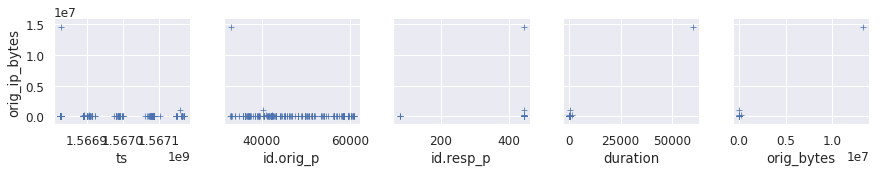

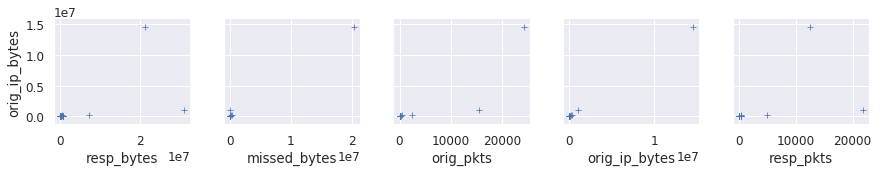

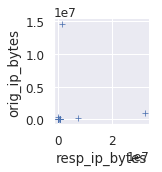

In [122]:
colors = "bgrcmykw"
color_index = 0
for i in range(0, len(df_num_RSTO.columns), 5):
    sns.pairplot(data=df_num_RSTO,
                x_vars=df_num_RSTO.columns[i:i+5],
                y_vars=['orig_ip_bytes'],
                markers="+")

                

## Feature to feature relationship


In [123]:
corr = df_num.corr()
print (corr)

                     ts  id.orig_p  id.resp_p  duration  orig_bytes  \
ts             1.000000  -0.022522  -0.019963 -0.011221   -0.000825   
id.orig_p     -0.022522   1.000000   0.446607 -0.007838    0.008268   
id.resp_p     -0.019963   0.446607   1.000000  0.002119    0.005494   
duration      -0.011221  -0.007838   0.002119  1.000000    0.312963   
orig_bytes    -0.000825   0.008268   0.005494  0.312963    1.000000   
resp_bytes     0.004180   0.003760  -0.001694  0.006151    0.807130   
missed_bytes   0.003013   0.003318  -0.001867  0.018994    0.843647   
orig_pkts      0.003201   0.003477  -0.001697  0.027244    0.818706   
orig_ip_bytes  0.002799   0.004105  -0.001464  0.062791    0.858564   
resp_pkts      0.003310   0.003308  -0.001767  0.008428    0.808166   
resp_ip_bytes  0.003327   0.003206  -0.001697  0.005942    0.806306   

               resp_bytes  missed_bytes  orig_pkts  orig_ip_bytes  resp_pkts  \
ts               0.004180      0.003013   0.003201       0.002799  

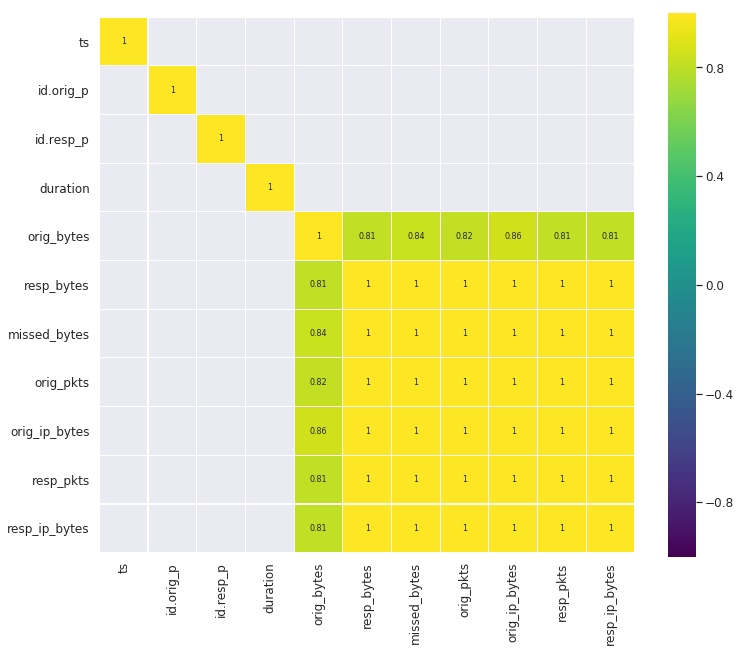

In [124]:
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

## Quantitative to Quantitative relationship

In [125]:
quantitative_features_list = ['id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts',
    'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

id.orig_p  id.resp_p  duration  orig_bytes  resp_bytes  missed_bytes  \
0      42064       1900  3.001863       688.0         0.0             0   
1      50598       4506  3.027828         0.0         0.0             0   
2      52149         53  0.014235       191.0       319.0             0   
3      48998         53  0.021023       103.0       217.0             0   
4      60754         53  0.016985       191.0       319.0             0   

   orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes  
0          4            800          0              0  
1          3            180          0              0  
2          2            247          2            375  
3          2            159          2            273  
4          2            247          2            375

# Ovo su vrijednosti na koje smo se kasnije i fokusirali

In [126]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse

['id.orig_p',
 'duration',
 'orig_bytes',
 'resp_bytes',
 'missed_bytes',
 'orig_pkts']

## Pregled distribucije vrijednosti u odosnu na parametar duration

/home/vlado/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


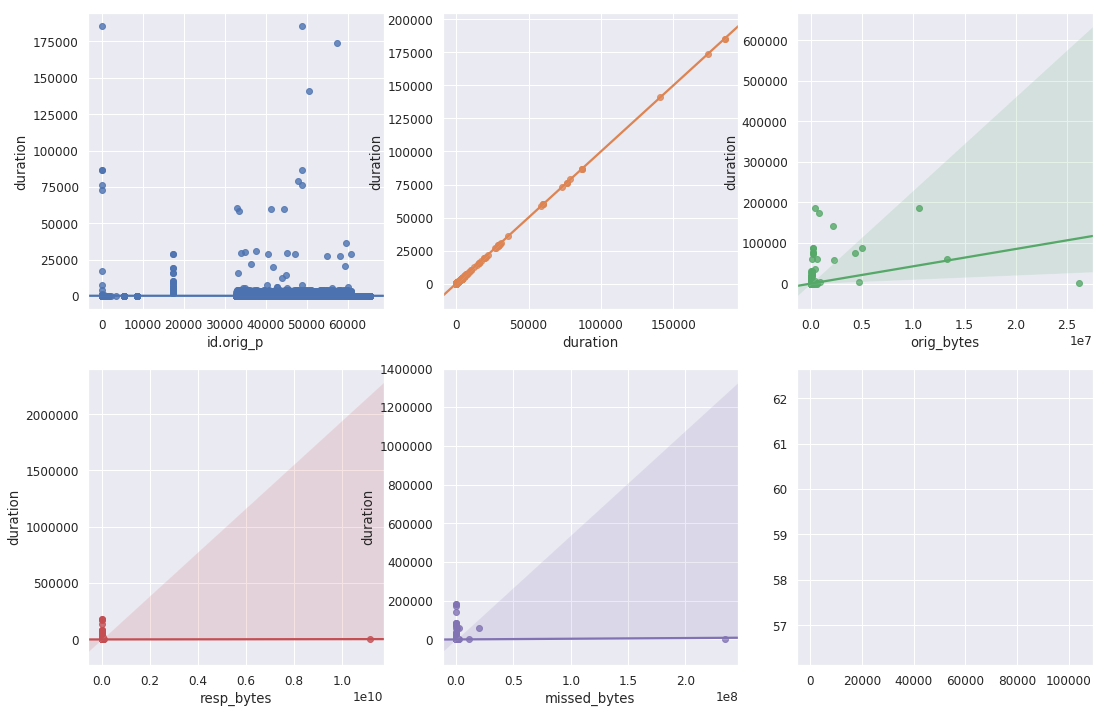

In [127]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='duration', data=df[features_to_analyse], ax=ax)

## Count missing values

In [128]:
print('TRAIN DATA- ',end=' ')
if(any(df.isnull().any())):
    print('Missing Data\n')
    print(df.isnull().sum())
else:
    print('NO missing data')

TRAIN DATA-  Missing Data

ts                    0
uid                   0
id.orig_h             0
id.orig_p             0
id.resp_h             0
id.resp_p             0
proto                 0
duration          73317
orig_bytes        73317
resp_bytes        73317
conn_state            0
local_orig            0
local_resp            0
missed_bytes          0
history           71270
orig_pkts             0
orig_ip_bytes         0
resp_pkts             0
resp_ip_bytes         0
service          132654
dtype: int64


## Visualization of service and conn_state counted  values

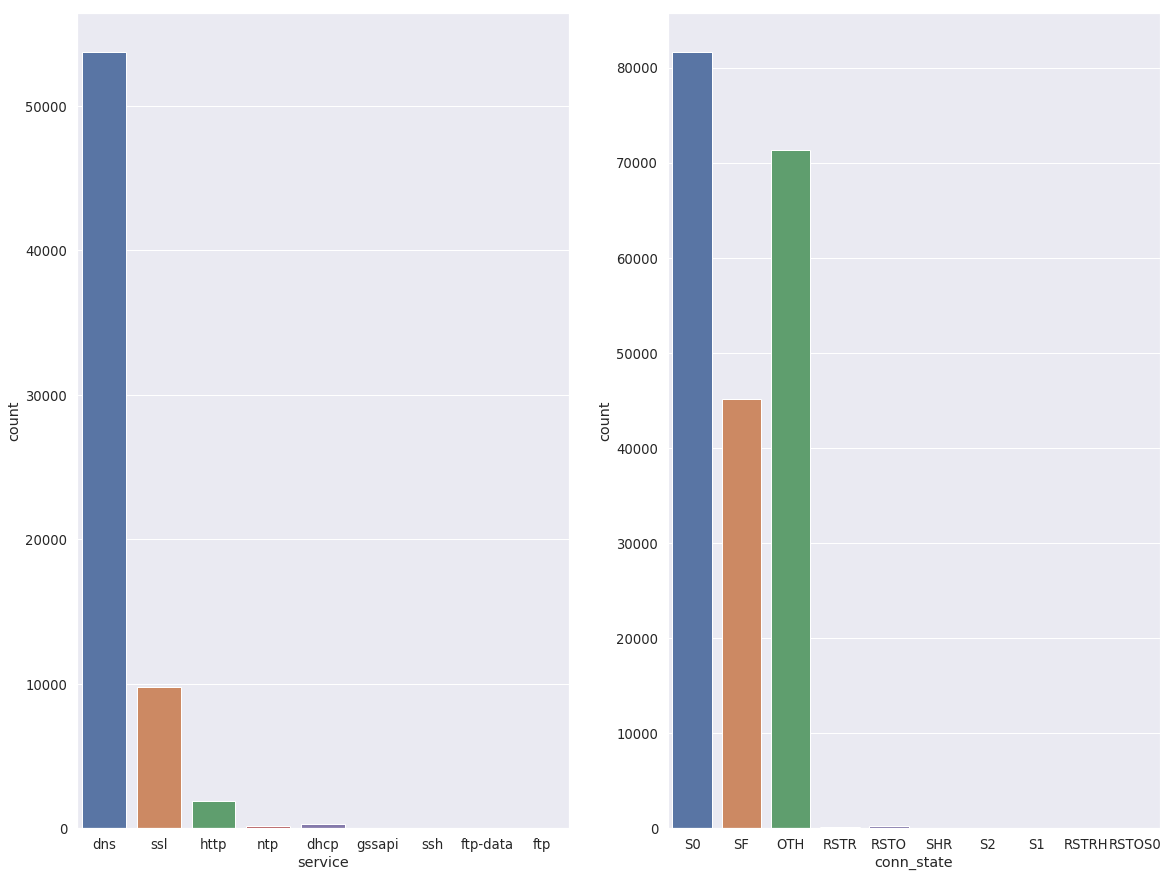

In [129]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.2)
plt.subplot(131)
sns.countplot(df['service'])
plt.subplot(132)
sns.countplot(df['conn_state'])



Potrebno izolirati vrijednosti za koje se smatra da je anomalija prema dosadasnjoj analizi
- uskladiti datasetove i razjasniti tocno (anomaliju)
- dublje analizirati radove o detekciji anomalija